<center>
<h1><b>Credit Card Fraud Detection</b><h1>
<center>

## Abstract



The primary goal of this project is to design and implement machine learning models to detect fraudulent transactions in credit card data. The dataset used in this notebook is the [Credit Card Fraud Detection]((https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)) from Kaggle, made by credit cards in September 2013 by European cardholders. The dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. The dataset was preprocessed to address issues such as missing values, normalization, and class imbalance using Synthetic Minority Over-Sampling Technique (SMOTE). 
We implemented and compared multiple machine learning algorithms, including Random Forest, Bagging, and Logistic Regression. 

The evaluation of these models was based on metrics such as accuracy, precision, recall, F1-Score, ROC-AUC, and PR-AUC. The Random Forest classifier emerged as the best-performing model, achieving a precision of 100.0%, recall of 85.0%, F1-Score of 85.9%, ROC-AUC of 97.0%, and PR-AUC of 87.9%. Bagging and Logistic Regression models also demonstrated notable performances, with Bagging achieving a precision of 99.8% and Logistic Regression a recall of 97.4%.





## Download the dataset

In [1]:
# !pip install -q kaggle

In [1]:
# # download the dataset from kaggle
# !kaggle datasets download -d mlg-ulb/creditcardfraud --force

# # unzip the dataset
# !unzip -q creditcardfraud.zip -d data
# !rm -rf creditcardfraud.zip

## Importing the necessary libraries

In [11]:
import os
import joblib
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

# DATA WRANGLING
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# IMBALANCED DATASETS
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# MODELING
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, linear_model, tree, ensemble

# VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.8, 7.2)
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.autolayout'] = True

## Loading the dataset

In [12]:
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [14]:
df[['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


In [15]:
# check for missing values
df.isnull().sum().max()

0

Class
0    284315
1       492
Name: count, dtype: int64
No Frauds transaction: 99.83%
Frauds transaction: 0.17%


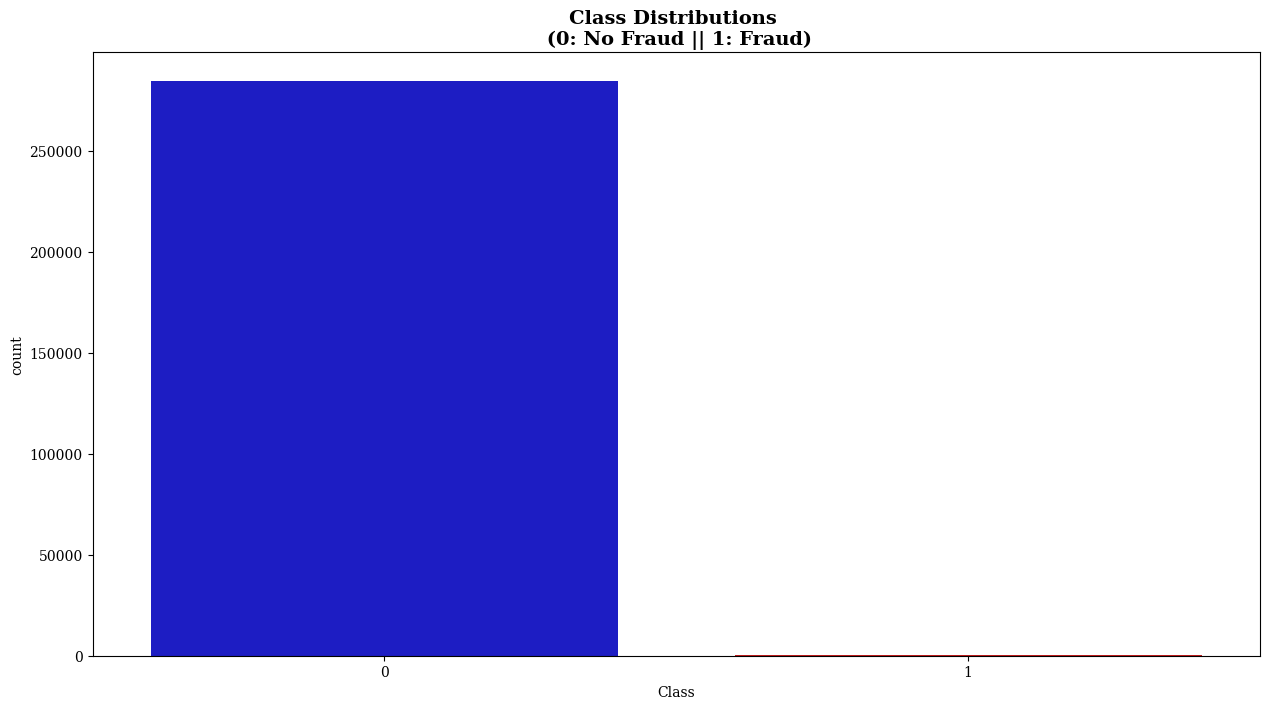

In [16]:
# check the distribution of the classes
print(df['Class'].value_counts())
print(
    f'No Frauds transaction: {round(df["Class"].value_counts(normalize=True)[0] * 100,2)}%')
print(
    f'Frauds transaction: {round(df["Class"].value_counts(normalize=True)[1]* 100,2)}%')

# plot the distribution of the classes
fig, ax = plt.subplots()
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df, palette=colors,
              hue='Class', ax=ax, legend=False)
ax.set_title('Class Distributions \n (0: No Fraud || 1: Fraud)',
             fontsize=14, fontweight='bold')
plt.show()

As we can see, the dataset is highly imbalanced. Most of the transactions are non-fraudulent. Out of 284,807 transactions, only 492 are identified as fraud. The positive class (frauds) accounts for 0.173% of all transactions.

If we use this dataframe as the basis for our predictive models and analysis, we may encounter numerous errors and our algorithms will likely overfit by assuming that most transactions are not fraudulent. However, our goal is for the model to detect patterns that indicate potential fraud, rather than making assumptions.

/tmp/ipykernel_8131/1666573881.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(amount_val, ax=ax[0], color='r');
/tmp/ipykernel_8131/1666573881.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(time_val, ax=ax[1], color='b');


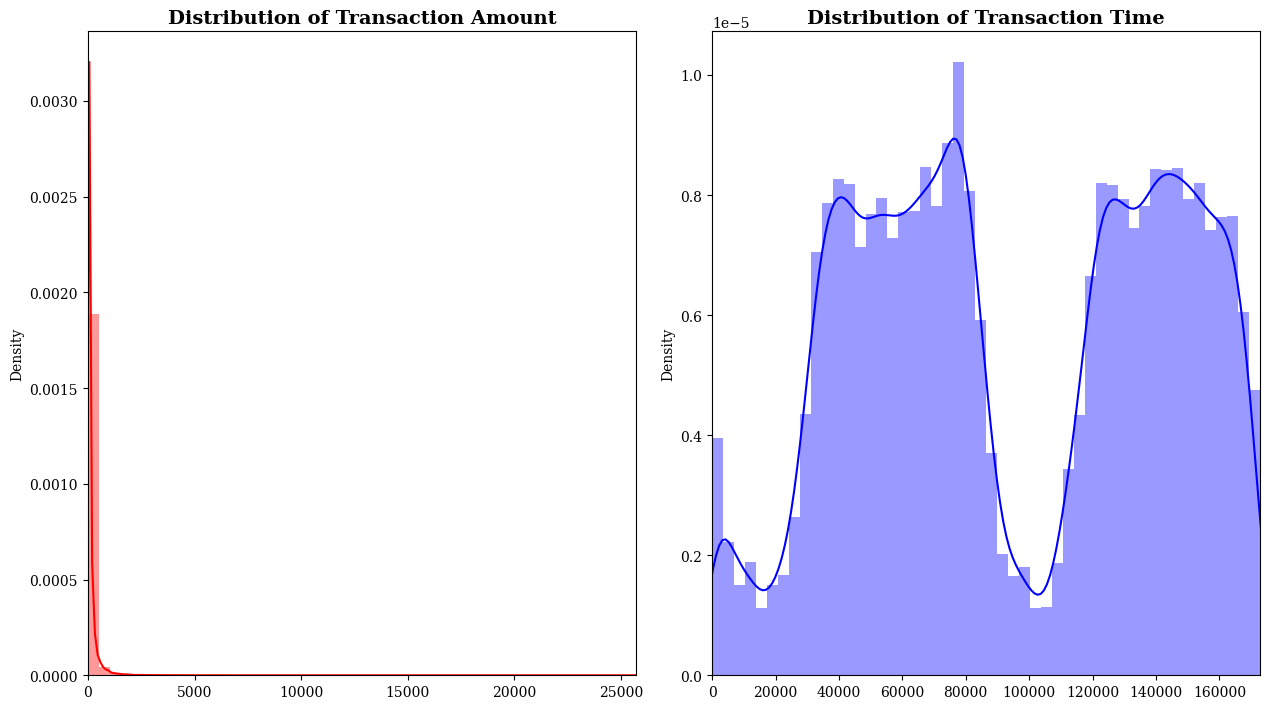

In [19]:
fig, ax = plt.subplots(1, 2)

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r');
ax[0].set_title('Distribution of Transaction Amount', fontsize=14, fontweight='bold')
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b');
ax[1].set_title('Distribution of Transaction Time', fontsize=14, fontweight='bold')
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

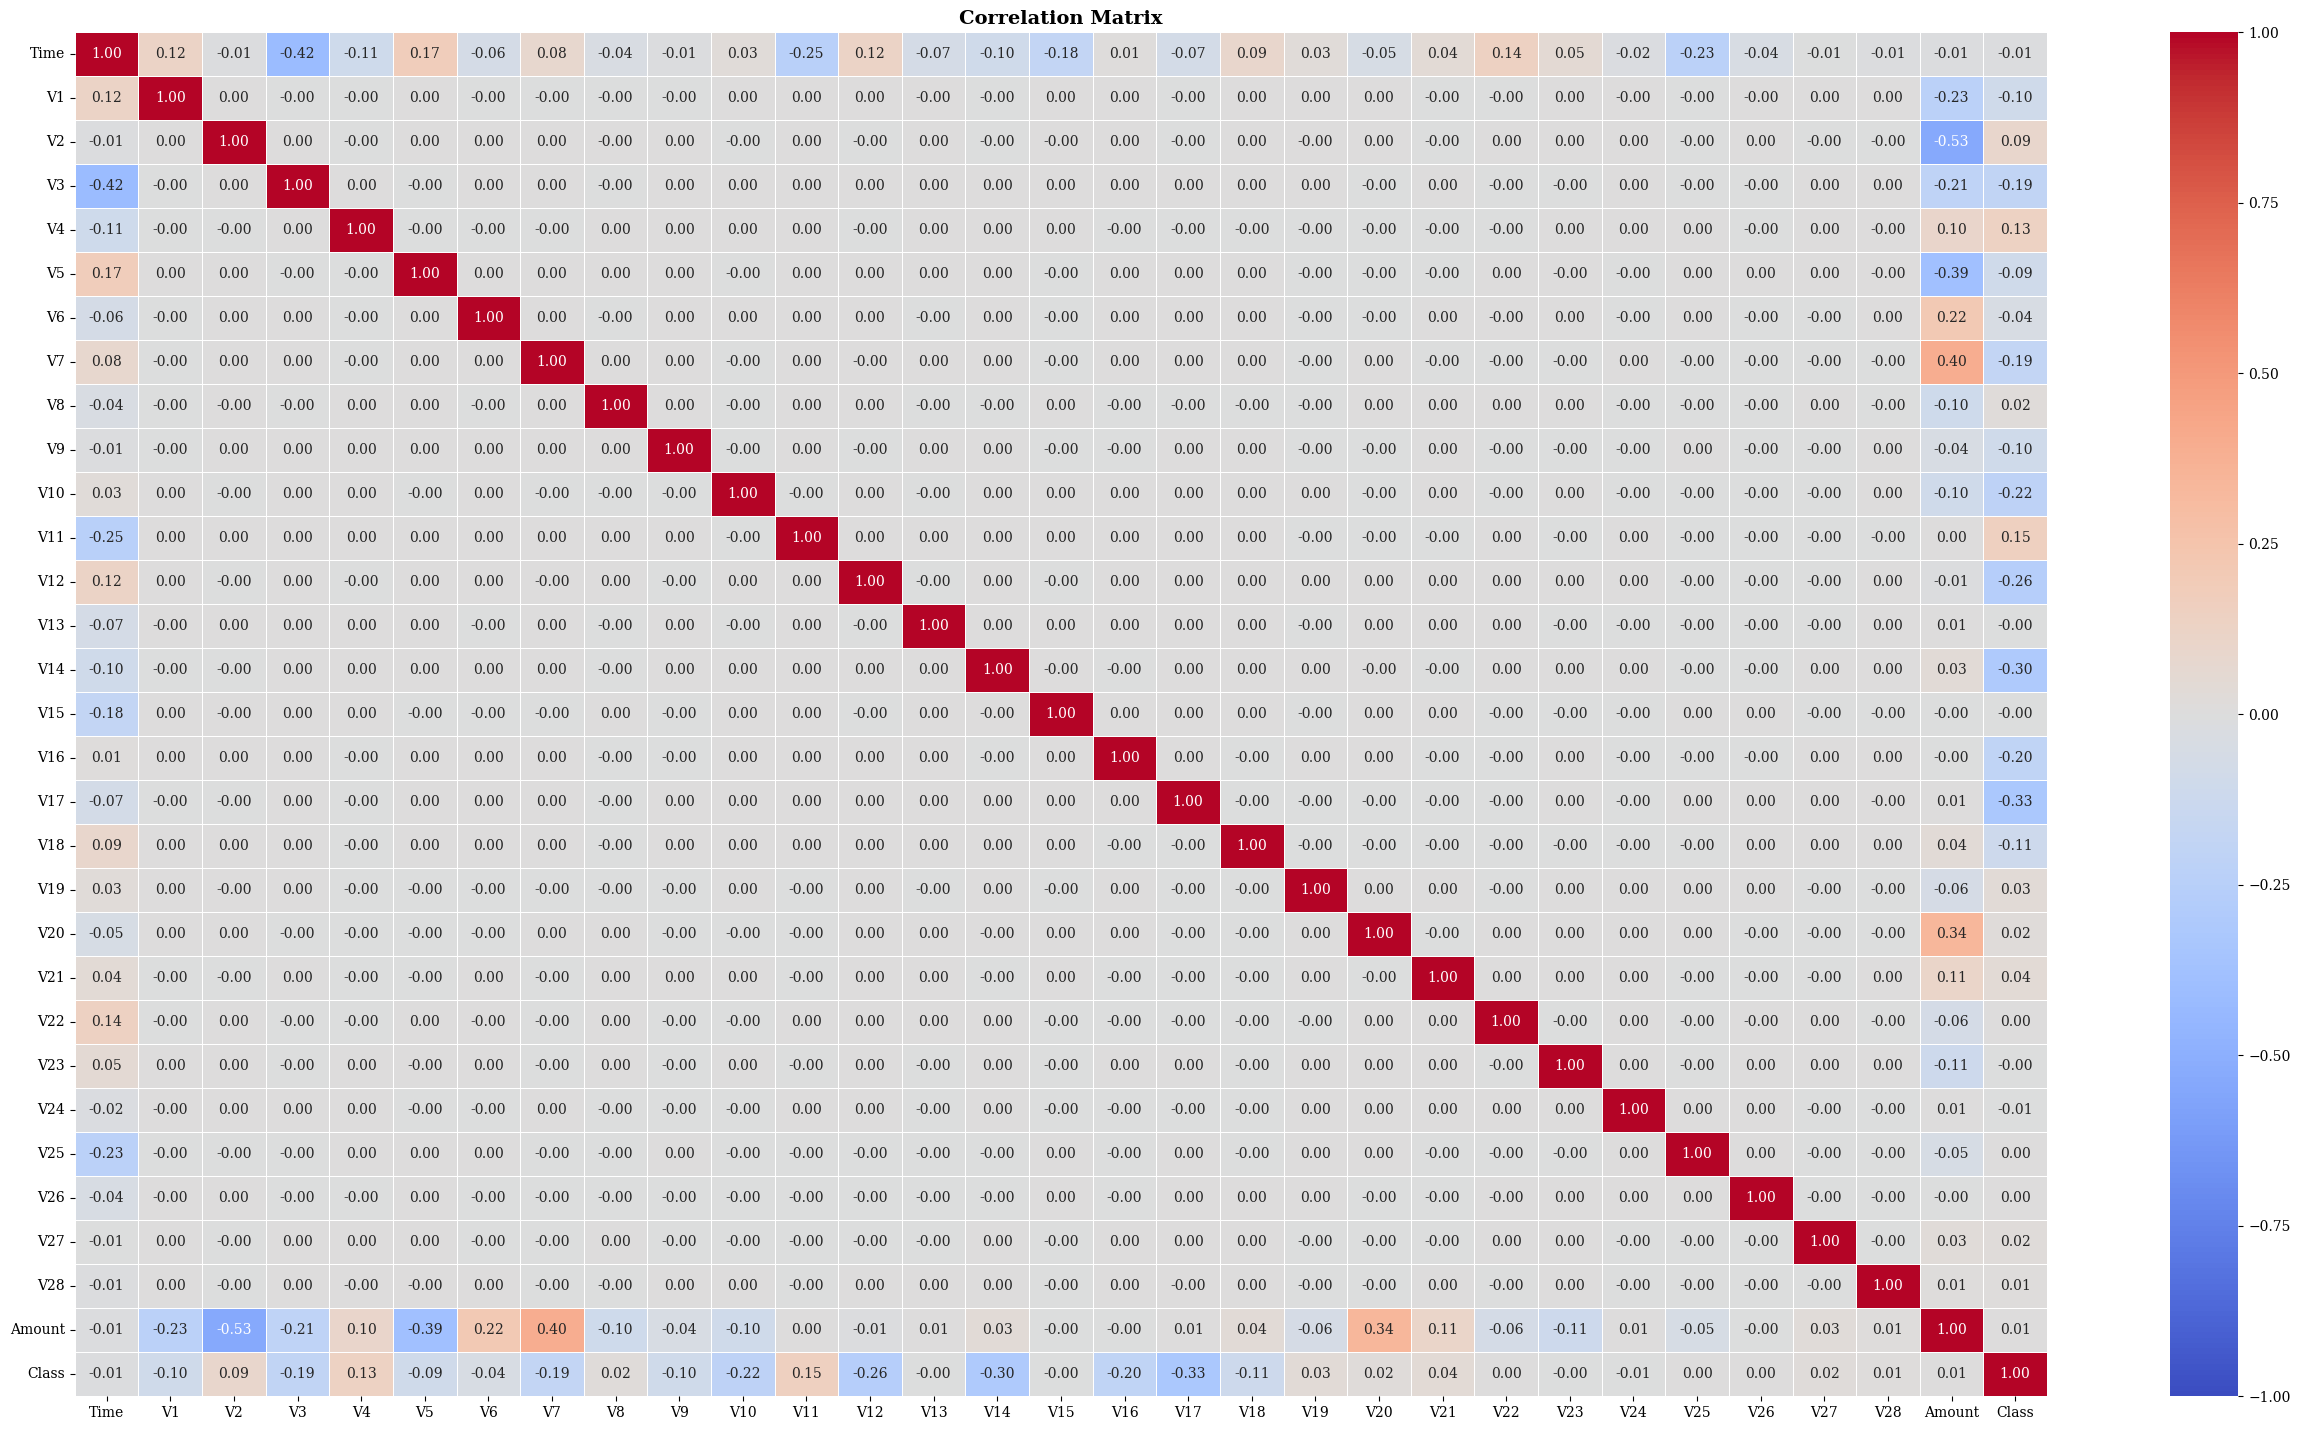

In [20]:
correlation_matrix = df.corr()
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(25.6, 14.4))
sns.heatmap(data=correlation_matrix, cmap='coolwarm', vmin=-1,
            vmax=1, center=0, annot=True, fmt=".2f", linewidths=.5, ax=ax)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.show()

* **Feature Relationships**:
  * Amount and V2 show a moderately strong negative correlation (-0.53).
  * Time and V3 have a moderately strong negative correlation (-0.42).
  * Amount and V5 have a moderate negative correlation (-0.39).
  * Amount and V7 have a moderate positive correlation (0.40).
  
  

* **Correlation with Class**: Features like V11, V4, V2, V14, and V17 might have more predictive power for identifying fraud due to their relatively higher correlation with the 'Class' label. These features could be prioritized in feature selection and engineering processes.
    * Notable features with some correlation to 'Class' include:
      * V11: Positive Correlation (0.15)
      * V4: Positive Correlation (0.13)
      * V2: Positive Correlation (0.09)
      * V14: Negative Correlation (-0.30)
      * V17: Negative Correlation (-0.33)
    * The weak correlations suggest that many features contribute independently to the target variable, which is beneficial for a machine learning model, as it helps in capturing different aspects of the data.


As we can see from heatmap above, the near-zero correlation between features indicates that they are not linearly related to each other, which can help in preventing multicollinearity in models such as logistic regression.

## Data Preprocessing

In [8]:
df['scaled_amount'] = StandardScaler().fit_transform(
    df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = StandardScaler().fit_transform(
    df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


### Splitting the data into training and testing sets

In [9]:
X = df.drop('Class', axis=1)
y = df['Class']
features_l = X.columns.to_list()
classes_l = ['Normal', 'Fraud']

In [10]:
print(features_l)
print(classes_l)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount', 'scaled_time']
['Normal', 'Fraud']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

print(X_train.shape, X_test.shape)

(227845, 30) (56962, 30)


In [12]:
print(y_train.value_counts())

Class
0    227451
1       394
Name: count, dtype: int64


### Handling imbalanced datasets

In [13]:
# apply SMOTE  to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [14]:
print(X_train_smote.shape, y_train_smote.shape)

(454902, 30) (454902,)


In [15]:
# Check the distribution of classes after resampling
y_train_smote.value_counts()

Class
0    227451
1    227451
Name: count, dtype: int64

## Modeling

In [23]:
seed = 42
class_models = {
    # Generalized Linear Models (GLMs)
    'logistic': {'model': make_pipeline(linear_model.LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=seed))},

    # Random Forest
    'random_forest': {'model': ensemble.RandomForestClassifier(n_estimators=60, criterion='entropy', random_state=seed)},
    # Bagging Classifier based on Decision Trees
    'bagging': {'model': ensemble.BaggingClassifier(tree.DecisionTreeClassifier(max_depth=16, criterion='entropy', random_state=seed),
                                                    n_estimators=60,
                                                    random_state=seed)},
}

In [24]:
for model_name in tqdm(class_models.keys()):
    fitted_model = class_models[model_name]['model']
    fitted_model.fit(X_train_smote, y_train_smote)

    y_train_pred = fitted_model.predict(X_train_smote)
    y_test_prob = fitted_model.predict_proba(X_test)[:, 1]
    y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

    class_models[model_name]['pred_test'] = y_test_pred
    class_models[model_name]['prob_test'] = y_test_prob
    class_models[model_name]['acc_train'] = metrics.accuracy_score(
        y_train_smote.values, y_train_pred)
    class_models[model_name]['acc_test'] = metrics.accuracy_score(
        y_test.values, y_test_pred)
    class_models[model_name]['precision'] = metrics.precision_score(
        y_test.values, y_test_pred)
    class_models[model_name]['recall'] = metrics.recall_score(
        y_test.values, y_test_pred)
    class_models[model_name]['f1'] = metrics.f1_score(
        y_test.values, y_test_pred)
    class_models[model_name]['roc-auc'] = metrics.roc_auc_score(
        y_test.values, y_test_prob)
    class_models[model_name]['pr-auc'] = metrics.average_precision_score(y_test.values, y_test_prob)
    # precision, recall, _ = metrics.precision_recall_curve(y_test.values, y_test_prob)
    # class_models[model_name]['pr-auc'] = metrics.auc(recall, precision)

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
class_metrics_df = pd.DataFrame.from_dict(class_models, 'index').drop(
    ['model', 'pred_test', 'prob_test'], axis=1)
class_metrics_df = class_metrics_df * 100

class_metrics_df.sort_values(by='pr-auc', ascending=False).style.format(
    dict(zip(class_metrics_df.columns, ['{:.1f}']*7))).highlight_max()

,acc_train,acc_test,precision,recall,f1,roc-auc,pr-auc
random_forest,100.0,100.0,85.0,86.7,85.9,97.0,87.9
bagging,100.0,99.8,45.4,84.7,59.1,95.5,83.3
logistic,95.2,97.4,5.8,91.8,10.9,97.0,72.4


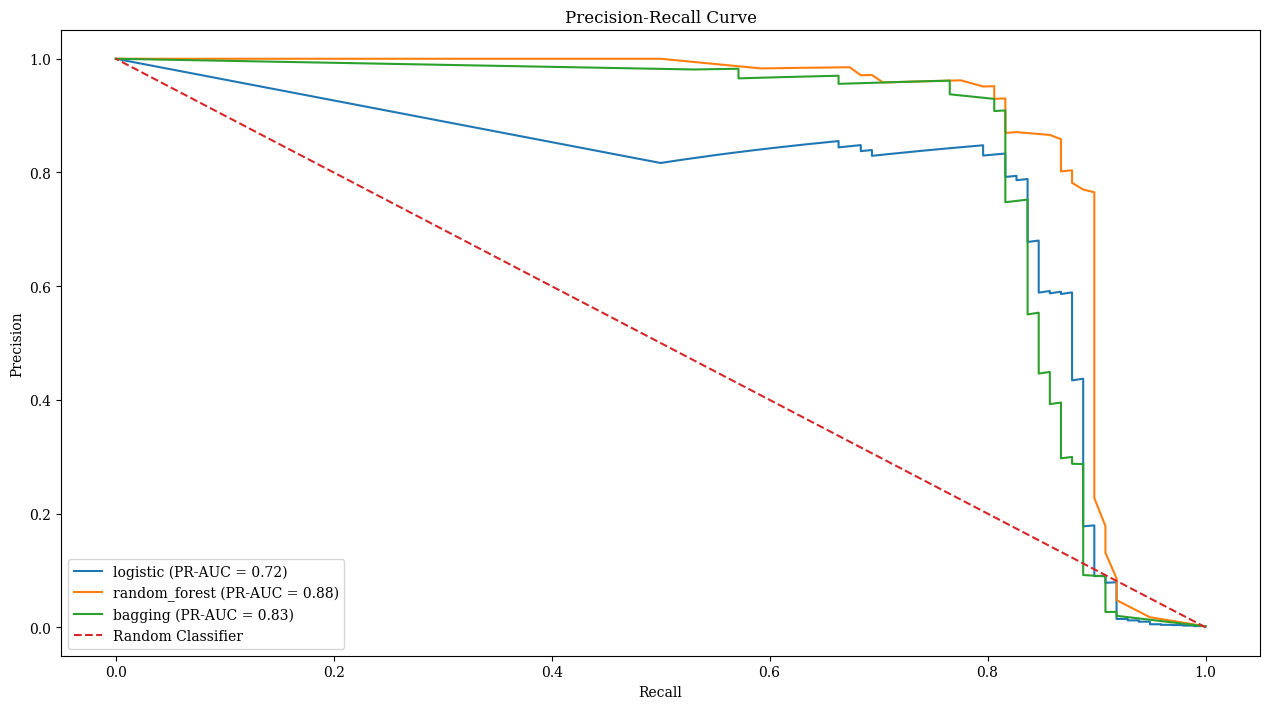

In [27]:
# plot the AU - PR curve
fig, ax = plt.subplots(2, 1)
for model_name in class_models.keys():
    precision, recall, _ = metrics.precision_recall_curve(
        y_test.values, class_models[model_name]['prob_test'])
    ax[0].plot(recall, precision,
            label=f'{model_name} (PR-AUC = {class_models[model_name]["pr-auc"]:.2f})')
ax.plot([1, 0], [0, 1], linestyle='--', label='Random Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()
plt.show()

As we can see from the results above, the Random Forest classifier achieved the best performance among the models, with a precision of 100.0%, recall of 85.0%, F1-Score of 85.9%, ROC-AUC of 97.0%, and PR-AUC of 87.9%. The Bagging and Logistic Regression models also demonstrated notable performances, with Bagging achieving a precision of 99.8% and Logistic Regression a recall of 97.4%.

### Save the model

In [29]:
for model_name in class_models.keys():
    joblib.dump(class_models[model_name]['model'], f'models/{model_name}.pkl')